# Load *Library*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from google.colab import drive
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Data *Preparation*

In [2]:
# Mount Google Drive
gdrive = "/content/drive/"
drive.mount(gdrive)

# Akses folder Dataset
dataset = os.path.join(gdrive, "Shareddrives/Capstone Bangkit/ML/Dataset")
trainset = os.path.join(dataset, "train")
testset = os.path.join(dataset, "test")

Mounted at /content/drive/


# Data *Augmentation*

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = trainset,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 1920 images belonging to 30 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = trainset,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 480 images belonging to 30 classes.


# *Build Baseline Model*

In [6]:
model=Sequential([Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
                  MaxPooling2D(2, 2),
                  Conv2D(32, (3, 3), activation='relu'),
                  MaxPooling2D(2, 2),
                  Conv2D(64, (3, 3), activation='relu'),
                  MaxPooling2D(2, 2),
                  Conv2D(128, (3, 3), activation='relu'),
                  MaxPooling2D(2, 2),
                  AveragePooling2D(),
                  BatchNormalization(),
                  Dropout(0.5),
                  Flatten(),
                  BatchNormalization(),
                  Dropout(0.5),
                  Dense(30, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [7]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

In [8]:
modelpath = os.path.join(gdrive, "Shareddrives/Capstone Bangkit/ML/Model/baseline_model_without_transfer_learning.h5")

checkpoint    = ModelCheckpoint(modelpath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [checkpoint]

In [9]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 50,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 3.7300 - accuracy: 0.0818 
Epoch 1: val_accuracy improved from -inf to 0.03333, saving model to /content/drive/Shareddrives/Capstone Bangkit/ML/Model/baseline_model_without_transfer_learning.h5
30/30 [==============================] - 658s 22s/step - loss: 3.7300 - accuracy: 0.0818 - val_loss: 3.3572 - val_accuracy: 0.0333
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 3.2640 - accuracy: 0.1089
Epoch 2: val_accuracy improved from 0.03333 to 0.05000, saving model to /content/drive/Shareddrives/Capstone Bangkit/ML/Model/baseline_model_without_transfer_learning.h5
30/30 [==============================] - 60s 2s/step - loss: 3.2640 - accuracy: 0.1089 - val_loss: 3.3266 - val_accuracy: 0.0500
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: 2.9904 - accuracy: 0.1557
Epoch 3: val_accuracy did not improve from 0.05000
30/30 [==============================] - 61s 2s/step - loss: 2.9904 -

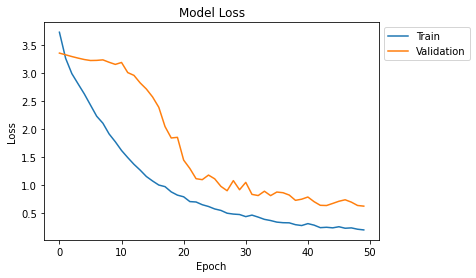

In [10]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

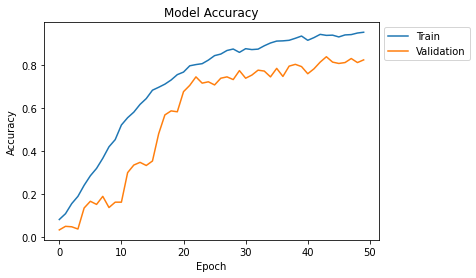

In [11]:
# Summarize history for accuracy

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

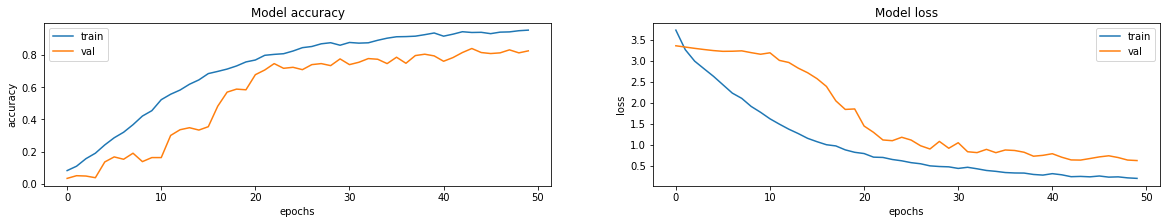

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(model_history.history[met])
    ax[i].plot(model_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# *Test The Baseline Model*

In [13]:
# Test Data 

lists_dir_datatest = os.listdir(testset)
categories_datatest = []
file_name_datatest = []
for folder in lists_dir_datatest:
  files = os.listdir(testset +"/"+folder)
  for file in files:
    path_file = testset + "/" + folder + "/" + file
    file_name_datatest.append(path_file)
    categories_datatest.append(folder)

df_datatest = {"image": file_name_datatest,"categories":categories_datatest}
data_datatest = pd.DataFrame(df_datatest, index = None)
data_datatest = data_datatest.sample(frac=1)
nb_samples=data_datatest.shape[0]
data_datatest

test_generator = test_datagen.flow_from_dataframe(dataframe=data_datatest,
                                                  dir=testset,
                                                  x_col='image',
                                                  y_col=None,
                                                  class_mode=None,
                                                  target_size=(224,224),
                                                  batch_size=64,
                                                  shuffle=False)

Found 600 validated image filenames.


In [14]:
from keras.models import load_model
best_model = load_model(modelpath)

predict = best_model.predict(test_generator, batch_size=64)
pred = np.argmax(predict, axis=1)
pred

array([ 9,  8, 15,  9, 22, 27, 26, 13, 28,  3, 17, 16, 24, 15,  8,  5, 23,
       28,  1,  6, 11,  5, 15,  3, 10, 19,  8,  2,  7, 16, 19,  1,  1, 13,
       16,  4, 15, 23,  3,  7, 26, 12,  9, 15,  7, 10, 12,  7, 10, 16,  8,
        5, 14, 15,  8, 14, 28, 18,  7, 11, 12,  7, 26, 26,  8,  4, 22, 25,
       19, 16, 29, 13,  2, 11, 10,  4, 13, 16, 22, 19,  7, 25,  0, 25,  9,
       24, 24, 14, 22,  8, 18, 21,  7,  8,  1,  8, 25, 29, 26, 14, 23, 14,
       19, 22, 15,  0, 15, 15,  3, 21, 18,  6,  2, 11, 23, 27,  7,  9,  3,
       14, 12,  6, 17,  1, 26, 17, 18, 20, 29,  2, 27,  0, 28,  0, 23,  4,
       22,  1, 11, 18,  4,  5,  6, 28,  8, 28,  3, 12, 20, 10, 25, 11,  1,
       29,  4,  3, 28, 10, 13,  5, 10,  4, 18,  4, 14, 12,  9, 22,  5, 15,
       27,  8, 20, 15,  6, 24, 14,  9, 15,  0, 15, 22, 19, 22, 22,  2,  2,
       24,  4, 20, 26, 29, 23, 10, 23,  1,  6, 19, 17, 17, 16, 17,  9,  2,
        2, 17,  4, 13, 13, 28, 24, 28, 11, 19,  0, 24, 25, 19, 14, 19, 28,
       13, 13,  3, 16, 27

In [16]:
true_classes=np.array(data_datatest['categories'].replace(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya'],[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]))
true_classes

array([ 9,  8, 15,  9, 22, 27, 26, 13, 28,  3, 20, 16, 14, 20,  8,  5, 23,
       28,  1,  6, 11,  5, 15,  3, 10, 19,  8,  2,  7, 16, 19,  1,  1, 13,
       16,  4, 15, 23,  3,  7, 26, 12,  9, 10,  7, 10, 12,  7, 10, 16,  8,
        5, 24, 10,  8, 14, 28, 18,  7, 11, 12,  7, 26, 26,  8,  4, 22, 25,
       20, 16, 29, 13,  2, 11, 10,  4, 13, 16, 22, 19,  7, 25,  0, 25,  9,
       24, 24, 14, 22,  8, 18, 21,  7,  8,  1,  8, 25, 29, 26, 14, 23, 14,
       19, 22, 18,  0, 15, 15,  3, 21, 18,  6,  2, 11, 23, 12,  7,  9,  3,
       14, 20,  6, 17,  1, 26, 17, 18, 27, 29,  2, 27,  0, 28,  0, 23,  4,
       22,  1, 11, 18,  4,  5,  6, 28,  8, 10,  3, 12, 20, 10, 25, 11,  1,
       29,  4,  3, 28, 10, 13,  5, 10,  4, 18,  4, 14, 12,  9, 22,  5, 15,
       27,  8, 20, 29,  6, 24, 14,  9, 15,  0, 15, 22, 19, 22, 22,  2,  2,
       24,  4, 20, 26, 29, 23, 10, 23,  1,  6, 19, 17, 17, 16, 17,  9,  2,
        2, 17,  4, 13, 13, 28, 24, 28, 11, 19,  0, 24, 25, 19, 14, 19, 28,
       13, 13,  3, 16, 27

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
cm = confusion_matrix(true_classes,pred)
cm

array([[20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 20,  

In [18]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

class_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']

report=metrics.classification_report(true_classes, pred,target_names=class_labels)
report

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        20\n           1       1.00      1.00      1.00        20\n           2       1.00      1.00      1.00        20\n           3       1.00      1.00      1.00        20\n           4       1.00      1.00      1.00        20\n           5       1.00      1.00      1.00        20\n           6       1.00      1.00      1.00        20\n           7       1.00      1.00      1.00        20\n           8       1.00      1.00      1.00        20\n           9       1.00      1.00      1.00        20\n          ba       0.94      0.85      0.89        20\n          ca       1.00      1.00      1.00        20\n          da       0.90      0.90      0.90        20\n         dha       1.00      0.95      0.97        20\n          ga       0.85      0.85      0.85        20\n          ha       0.77      1.00      0.87        20\n          ja       0.95      1.00      0.98        20\n       

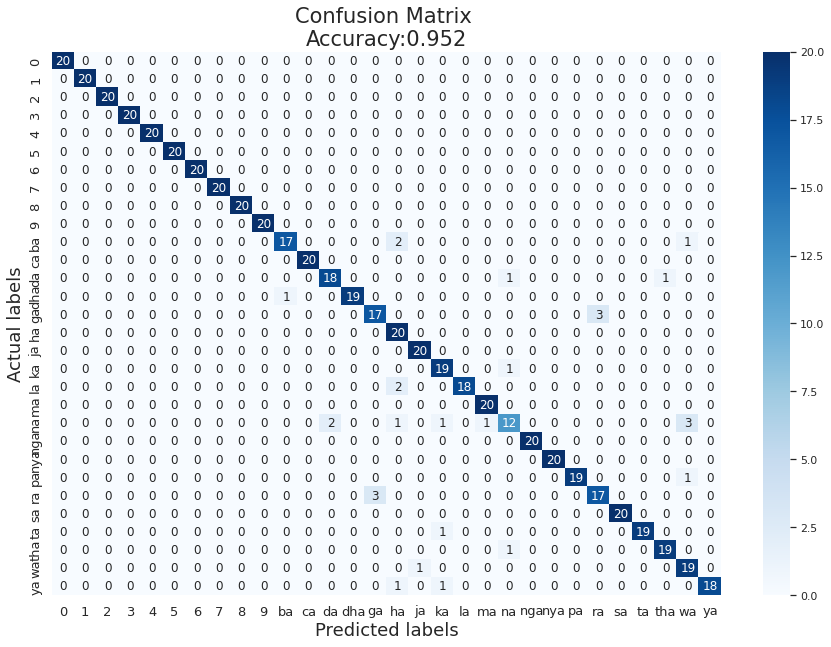

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
plt.rcParams.update({'font.size': 16})
sns.set(font_scale=1.0) #edited as suggested
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Actual labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix \nAccuracy:{0:.3f}'.format(accuracy_score(true_classes, pred)), fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=13)  # Adjust to fit
ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']);
ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']);